# newly try

In [1]:
# Optional: if these are already installed, Colab just skip করবে
!pip install pandas numpy matplotlib scikit-learn --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# hotel_bookings.csv ফাইল লোড
df = pd.read_csv("/content/drive/MyDrive/Hotel_Management/hotel_bookings.csv")

# ডেটার shape দেখার জন্য
print("Shape of data (rows, columns):", df.shape)

# প্রথম 5টা row দেখতে
df.head()


Shape of data (rows, columns): (119390, 32)


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [4]:
# Columns নাম ও dtype দেখে নেব
print(df.columns.tolist())

print("\nDataFrame info:")
df.info()


['hotel', 'is_canceled', 'lead_time', 'arrival_date_year', 'arrival_date_month', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'meal', 'country', 'market_segment', 'distribution_channel', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'reserved_room_type', 'assigned_room_type', 'booking_changes', 'deposit_type', 'agent', 'company', 'days_in_waiting_list', 'customer_type', 'adr', 'required_car_parking_spaces', 'total_of_special_requests', 'reservation_status', 'reservation_status_date']

DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   

In [5]:
# -----------------------------------------
# Step 2: Data Cleaning + Feature Creation
# -----------------------------------------

df['children'] = df['children'].fillna(0)
df['country'] = df['country'].fillna('Unknown')

# agent/company missing values → fill with 0
df['agent'] = df['agent'].fillna(0)
df['company'] = df['company'].fillna(0)

# 1) Total guests (tourism indicator)
df['total_guests'] = df['adults'] + df['children'] + df['babies']

# 2) Total stay nights (hospitality demand indicator)
df['stay_nights'] = df['stays_in_week_nights'] + df['stays_in_weekend_nights']

# 3) Tourism + hospitality combined demand score
df['demand_index'] = df['total_guests'] * df['stay_nights']

# 4) Family trip indicator
df['is_family_trip'] = df['children'].apply(lambda x: 1 if x > 0 else 0)

# 5) Month → numerical encode
month_map = {
    'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6,
    'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'December':12
}
df['arrival_month_num'] = df['arrival_date_month'].map(month_map)

# 6) Season feature
def season_from_month(m):
    if m in [12,1,2]:
        return 'Winter'
    elif m in [3,4,5]:
        return 'Spring'
    elif m in [6,7,8]:
        return 'Summer'
    else:
        return 'Autumn'

df['season'] = df['arrival_month_num'].apply(season_from_month)

# Check new columns
df[['total_guests','stay_nights','demand_index','is_family_trip','arrival_month_num','season']].head()


,total_guests,stay_nights,demand_index,is_family_trip,arrival_month_num,season
0,2.0,0,0.0,0,7,Summer
1,2.0,0,0.0,0,7,Summer
2,1.0,1,1.0,0,7,Summer
3,1.0,1,1.0,0,7,Summer
4,2.0,2,4.0,0,7,Summer


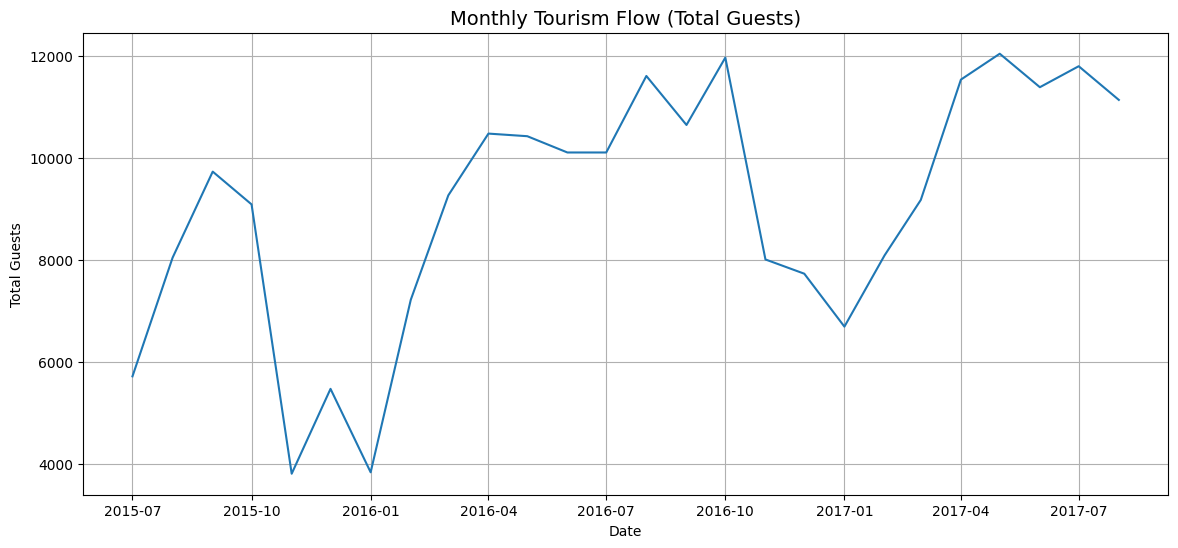

In [6]:
# Month-wise total guests
monthly_guests = df.groupby(['arrival_date_year', 'arrival_month_num'])['total_guests'].sum().reset_index()

# Combine year+month into single time index
monthly_guests['date'] = pd.to_datetime(monthly_guests['arrival_date_year'].astype(str) + "-" +
                                        monthly_guests['arrival_month_num'].astype(str) + "-01")

plt.figure(figsize=(14,6))
plt.plot(monthly_guests['date'], monthly_guests['total_guests'])
plt.title("Monthly Tourism Flow (Total Guests)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Total Guests")
plt.grid(True)
plt.show()


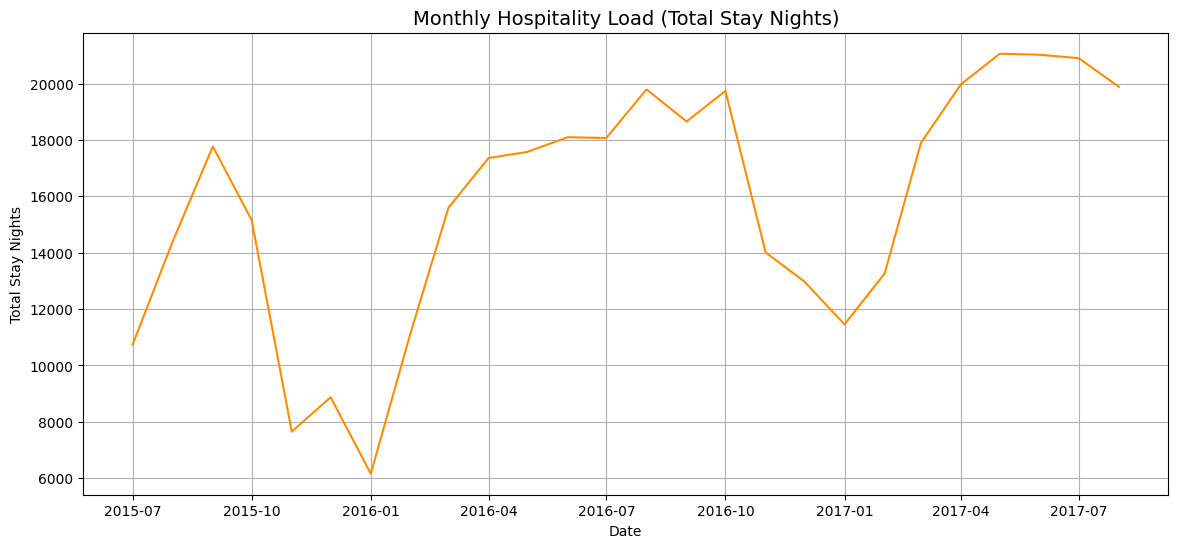

In [7]:
monthly_stay = df.groupby(['arrival_date_year','arrival_month_num'])['stay_nights'].sum().reset_index()
monthly_stay['date'] = pd.to_datetime(monthly_stay['arrival_date_year'].astype(str) + "-" +
                                      monthly_stay['arrival_month_num'].astype(str) + "-01")

plt.figure(figsize=(14,6))
plt.plot(monthly_stay['date'], monthly_stay['stay_nights'], color='darkorange')
plt.title("Monthly Hospitality Load (Total Stay Nights)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Total Stay Nights")
plt.grid(True)
plt.show()


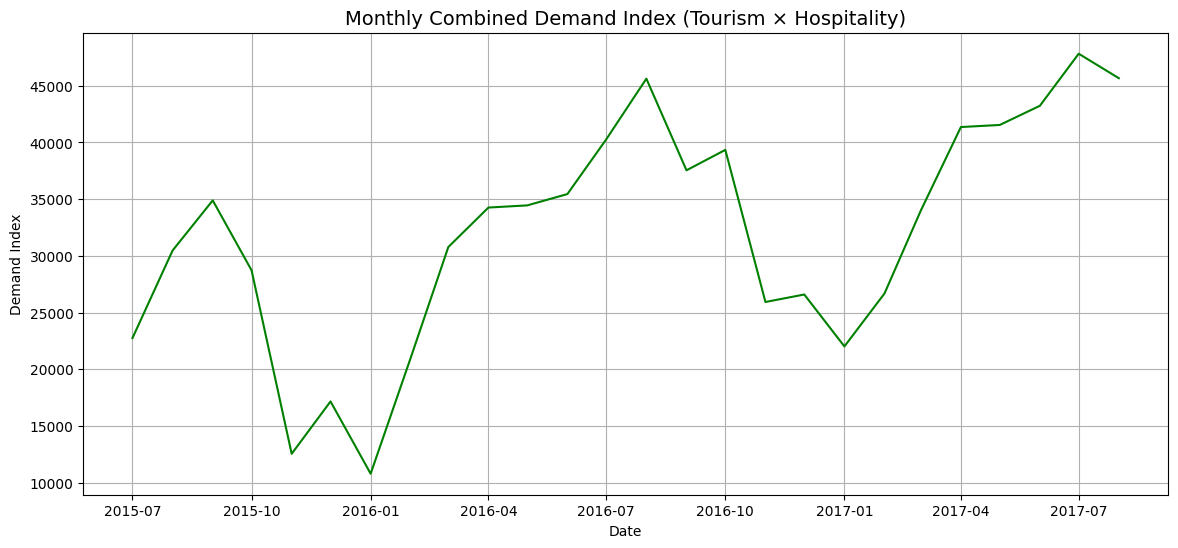

In [8]:
monthly_demand = df.groupby(['arrival_date_year','arrival_month_num'])['demand_index'].sum().reset_index()
monthly_demand['date'] = pd.to_datetime(monthly_demand['arrival_date_year'].astype(str) + "-" +
                                        monthly_demand['arrival_month_num'].astype(str) + "-01")

plt.figure(figsize=(14,6))
plt.plot(monthly_demand['date'], monthly_demand['demand_index'], color='green')
plt.title("Monthly Combined Demand Index (Tourism × Hospitality)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Demand Index")
plt.grid(True)
plt.show()


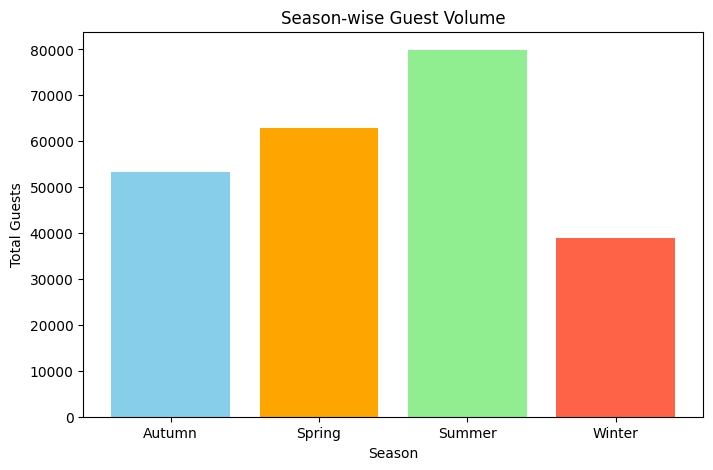

In [9]:
seasonal = df.groupby('season')['total_guests'].sum().reset_index()

plt.figure(figsize=(8,5))
plt.bar(seasonal['season'], seasonal['total_guests'], color=['skyblue','orange','lightgreen','tomato'])
plt.title("Season-wise Guest Volume")
plt.xlabel("Season")
plt.ylabel("Total Guests")
plt.show()


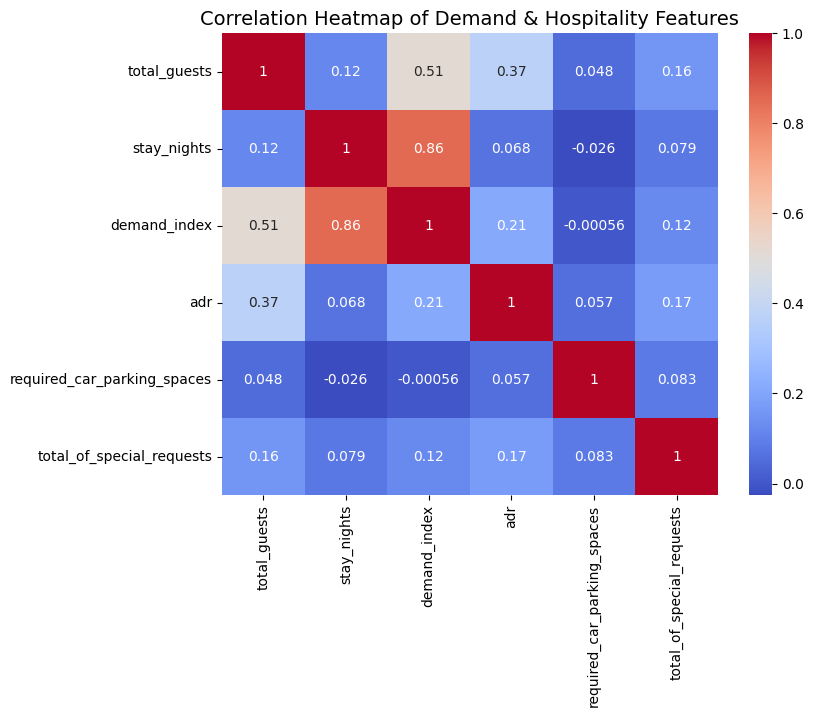

In [10]:
import seaborn as sns

plt.figure(figsize=(8,6))
sns.heatmap(df[['total_guests','stay_nights','demand_index','adr','required_car_parking_spaces',
                'total_of_special_requests']].corr(),
            annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap of Demand & Hospitality Features", fontsize=14)
plt.show()


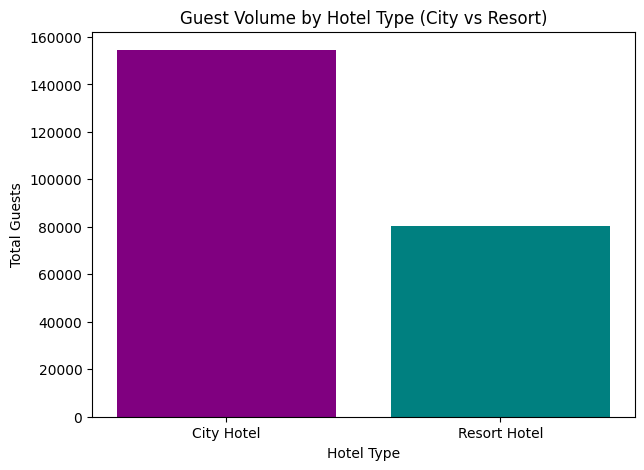

In [11]:
hotel_compare = df.groupby('hotel')['total_guests'].sum().reset_index()

plt.figure(figsize=(7,5))
plt.bar(hotel_compare['hotel'], hotel_compare['total_guests'], color=['purple','teal'])
plt.title("Guest Volume by Hotel Type (City vs Resort)")
plt.xlabel("Hotel Type")
plt.ylabel("Total Guests")
plt.show()


In [12]:
import pandas as pd
import numpy as np


df = df.copy()  # safety
# children NaN -> 0
df["children"] = df["children"].fillna(0)

# country NaN -> 'Unknown'
df["country"] = df["country"].fillna("Unknown")

# agent, company যেগুলো mostly ID-type / অনেক NaN -> drop
df = df.drop(columns=["company", "agent"], errors="ignore")

# --- Core hospitality features ---
df["stay_nights"]   = df["stays_in_weekend_nights"] + df["stays_in_week_nights"]
df["total_guests"]  = df["adults"] + df["children"] + df["babies"]
df["guest_nights"]  = df["stay_nights"] * df["total_guests"]

# arrival month number
month_map = {
    "January": 1, "February": 2, "March": 3, "April": 4,
    "May": 5, "June": 6, "July": 7, "August": 8,
    "September": 9, "October": 10, "November": 11, "December": 12
}
df["arrival_month_num"] = df["arrival_date_month"].map(month_map)

# --- Build a proper date column for time-based splitting ---
df["arrival_date"] = pd.to_datetime(
    df["arrival_date_year"].astype(str) + "-" +
    df["arrival_month_num"].astype(str) + "-" +
    df["arrival_date_day_of_month"].astype(str),
    errors="coerce"
)

print("Shape after basic engineering:", df.shape)
df[["arrival_date", "stay_nights", "total_guests", "guest_nights"]].head()


Shape after basic engineering: (119390, 38)


,arrival_date,stay_nights,total_guests,guest_nights
0,2015-07-01,0,2.0,0.0
1,2015-07-01,0,2.0,0.0
2,2015-07-01,1,1.0,1.0
3,2015-07-01,1,1.0,1.0
4,2015-07-01,2,2.0,4.0


In [13]:
# Create monthly-level overcrowding label ===

# 1) monthly aggregation (hotel + year + month)
monthly = (
    df.groupby(["hotel", "arrival_date_year", "arrival_month_num"])
      .agg(
          total_guests_month=("total_guests", "sum"),
          stay_nights_month=("stay_nights", "sum"),
          guest_nights_month=("guest_nights", "sum")
      )
      .reset_index()
)

# 2) Z-score based overcrowding score (from guest_nights_month)
mean_gn = monthly["guest_nights_month"].mean()
std_gn  = monthly["guest_nights_month"].std()

monthly["overcrowding_score"] = (monthly["guest_nights_month"] - mean_gn) / std_gn

# 3) Threshold for overcrowded month (e.g., score > 0.8)
thr = 0.8
monthly["overcrowded"] = (monthly["overcrowding_score"] > thr).astype(int)

print("Monthly overcrowded ratio:")
print(monthly["overcrowded"].value_counts(normalize=True))

monthly.head()


Monthly overcrowded ratio:
overcrowded
0    0.769231
1    0.230769
Name: proportion, dtype: float64


,hotel,arrival_date_year,arrival_month_num,total_guests_month,stay_nights_month,guest_nights_month,overcrowding_score,overcrowded
0,City Hotel,2015,7,2687.0,3766,7196.0,-1.498929,0
1,City Hotel,2015,8,4878.0,6750,13137.0,-0.485189,0
2,City Hotel,2015,9,6386.0,9641,17592.0,0.274987,0
3,City Hotel,2015,10,6029.0,8856,16106.0,0.021424,0
4,City Hotel,2015,11,1951.0,3591,5871.0,-1.725020,0


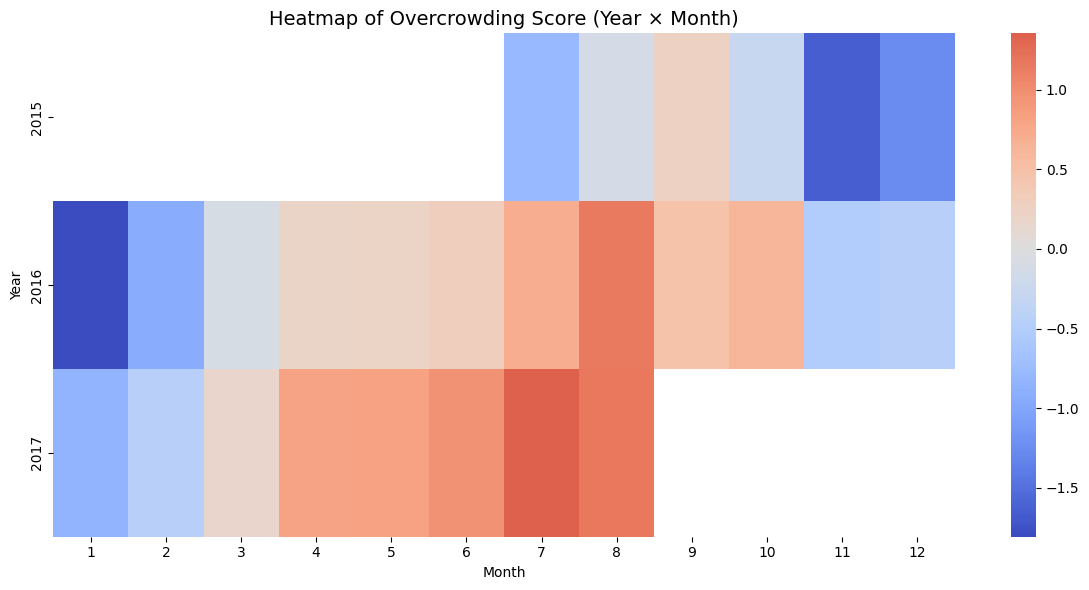

In [14]:
heat = monthly.pivot_table(
    index="arrival_date_year",
    columns="arrival_month_num",
    values="overcrowding_score",
    aggfunc="mean"
)

plt.figure(figsize=(12,6))
sns.heatmap(heat, annot=False, cmap="coolwarm", center=0)
plt.title("Heatmap of Overcrowding Score (Year × Month)", fontsize=14)
plt.xlabel("Month")
plt.ylabel("Year")
plt.tight_layout()
plt.show()


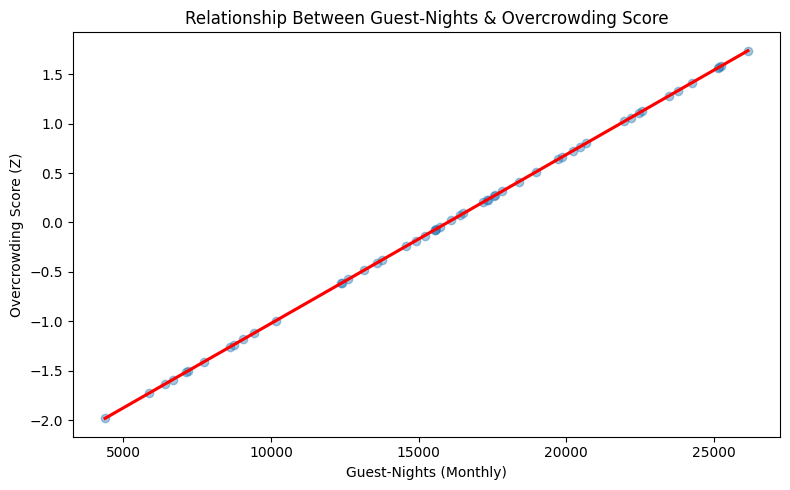

In [15]:
plt.figure(figsize=(8,5))
sns.regplot(
    data=monthly,
    x="guest_nights_month",
    y="overcrowding_score",
    scatter_kws={"alpha":0.4},
    line_kws={"color":"red"}
)
plt.title("Relationship Between Guest-Nights & Overcrowding Score")
plt.xlabel("Guest-Nights (Monthly)")
plt.ylabel("Overcrowding Score (Z)")
plt.tight_layout()
plt.show()


In [16]:
# === 3. Map monthly overcrowded back to each booking (robust version) ===

# 1) নিশ্চিত হই monthly তে ঠিক নামের কলাম আছে
if "overcrowded" not in monthly.columns:
    # হয়ত তুমি আগের কোথাও 'overcrowded_flag' নামে বানিয়েছিলে
    if "overcrowded_flag" in monthly.columns:
        monthly = monthly.rename(columns={"overcrowded_flag": "overcrowded"})
        print("Renamed 'overcrowded_flag' -> 'overcrowded' in monthly.")
    else:
        print("monthly columns:", monthly.columns.tolist())
        raise ValueError("monthly DataFrame এ 'overcrowded' কলাম পাওয়া যায়নি। আগে Cell-2 ঠিকমতো চালাও।")

# 2) df এ যদি আগের কোনো 'overcrowded' থাকে, আগে ড্রপ করে দেই
if "overcrowded" in df.columns:
    print("Dropping old 'overcrowded' from df to avoid conflict.")
    df = df.drop(columns=["overcrowded"])

# 3) Merge: hotel + year + month দিয়ে প্রতি booking এর সাথে monthly label attach
df = df.merge(
    monthly[["hotel", "arrival_date_year", "arrival_month_num", "overcrowded"]],
    on=["hotel", "arrival_date_year", "arrival_month_num"],
    how="left"
)

# 4) এখন crowded কলাম আছে কিনা চেক করি
if "overcrowded" not in df.columns:
    print("df columns after merge:", df.columns.tolist())
    raise ValueError("Merge এর পরেও 'overcrowded' কলাম তৈরি হয়নি। key mismatch হচ্ছে হয়তো।")

print("overcrowded value counts (with NaN):")
print(df["overcrowded"].value_counts(dropna=False))

# 5) NaN থাকা রো গুলো বাদ দেই (যদি কোনো মাস ম্যাপ না হয়)
before = len(df)
df = df.dropna(subset=["overcrowded"]).copy()
after = len(df)
print(f"Dropped {before - after} rows with NaN overcrowded.")

df["overcrowded"] = df["overcrowded"].astype(int)

print("\nFinal overcrowded distribution:")
print(df["overcrowded"].value_counts(normalize=True))

# 6) ======= DROP LEAKAGE COLUMNS =======
leak_cols = [
    "stay_nights", "total_guests", "guest_nights",
    "is_canceled", "reservation_status", "reservation_status_date",
    "days_in_waiting_list"
]

df = df.drop(columns=[c for c in leak_cols if c in df.columns])

print("\nColumns after dropping leakage:")
print(df.columns.tolist())


overcrowded value counts (with NaN):
overcrowded
0    78546
1    40844
Name: count, dtype: int64
Dropped 0 rows with NaN overcrowded.

Final overcrowded distribution:
overcrowded
0    0.657894
1    0.342106
Name: proportion, dtype: float64

Columns after dropping leakage:
['hotel', 'lead_time', 'arrival_date_year', 'arrival_date_month', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'meal', 'country', 'market_segment', 'distribution_channel', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'reserved_room_type', 'assigned_room_type', 'booking_changes', 'deposit_type', 'customer_type', 'adr', 'required_car_parking_spaces', 'total_of_special_requests', 'demand_index', 'is_family_trip', 'arrival_month_num', 'season', 'arrival_date', 'overcrowded']


/tmp/ipython-input-3642024082.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["overcrowded"], palette="Set2")


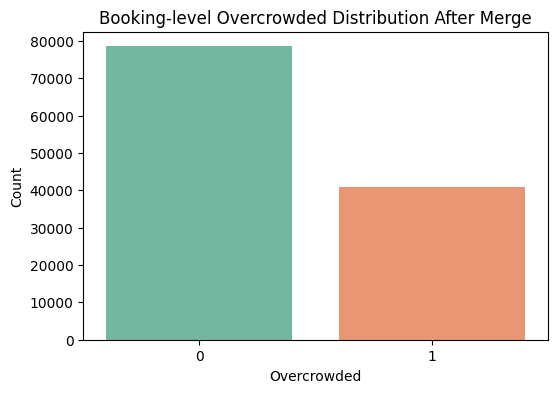

In [17]:
plt.figure(figsize=(6,4))
sns.countplot(x=df["overcrowded"], palette="Set2")
plt.title("Booking-level Overcrowded Distribution After Merge")
plt.xlabel("Overcrowded")
plt.ylabel("Count")
plt.show()


In [18]:
# Time-based split (70/15/15)

df = df.sort_values("arrival_date", ascending=True).reset_index(drop=True)

n = len(df)
train_end = int(n * 0.70)
valid_end = int(n * 0.85)

train_df = df.iloc[:train_end]
valid_df = df.iloc[train_end:valid_end]
test_df  = df.iloc[valid_end:]

print("Train samples:", len(train_df))
print("Valid samples:", len(valid_df))
print("Test samples :", len(test_df))

print("\nClass ratios:")
print("Train:", train_df["overcrowded"].value_counts(normalize=True))
print("Valid:", valid_df["overcrowded"].value_counts(normalize=True))
print("Test :", test_df["overcrowded"].value_counts(normalize=True))


Train samples: 83573
Valid samples: 17908
Test samples : 17909

Class ratios:
Train: overcrowded
0    0.782705
1    0.217295
Name: proportion, dtype: float64
Valid: overcrowded
0    0.603808
1    0.396192
Name: proportion, dtype: float64
Test : overcrowded
1    0.870456
0    0.129544
Name: proportion, dtype: float64


In [20]:
# Final Feature Setup (fixed, without leakage columns)

cat_cols = [
    'hotel', 'arrival_date_month', 'meal', 'country',
    'market_segment', 'distribution_channel',
    'reserved_room_type', 'assigned_room_type',
    'deposit_type', 'customer_type'
]

num_cols = [
    'lead_time',
    'arrival_date_year',
    'arrival_date_week_number',
    'arrival_date_day_of_month',
    'stays_in_weekend_nights',
    'stays_in_week_nights',
    'adults',
    'children',
    'babies',
    'is_repeated_guest',
    'previous_cancellations',
    'previous_bookings_not_canceled',
    'booking_changes',
    'adr',
    'required_car_parking_spaces',
    'total_of_special_requests',
    'arrival_month_num'
]

feature_cols = cat_cols + num_cols

# ছোট safety check
missing = [c for c in feature_cols if c not in train_df.columns]
print("Missing columns in train_df:", missing)

X_train = train_df[feature_cols].copy()
y_train = train_df["overcrowded"].copy()

X_valid = valid_df[feature_cols].copy()
y_valid = valid_df["overcrowded"].copy()

X_test  = test_df[feature_cols].copy()
y_test  = test_df["overcrowded"].copy()

print("Train shape:", X_train.shape)
print("Valid shape:", X_valid.shape)
print("Test shape :", X_test.shape)


Missing columns in train_df: []
Train shape: (83573, 27)
Valid shape: (17908, 27)
Test shape : (17909, 27)


In [21]:
# ===  Map monthly overcrowded back to each booking (robust version) ===

# 1) নিশ্চিত হই monthly তে ঠিক নামের কলাম আছে
if "overcrowded" not in monthly.columns:
    # হয়ত তুমি আগের কোথাও 'overcrowded_flag' নামে বানিয়েছিলে
    if "overcrowded_flag" in monthly.columns:
        monthly = monthly.rename(columns={"overcrowded_flag": "overcrowded"})
        print("Renamed 'overcrowded_flag' -> 'overcrowded' in monthly.")
    else:
        print("monthly columns:", monthly.columns.tolist())
        raise ValueError("monthly DataFrame এ 'overcrowded' কলাম পাওয়া যায়নি। আগে Cell-2 ঠিকমতো চালাও।")

# 2) df এ যদি আগের কোনো 'overcrowded' থাকে, আগে ড্রপ করে দেই
if "overcrowded" in df.columns:
    print("Dropping old 'overcrowded' from df to avoid conflict.")
    df = df.drop(columns=["overcrowded"])

# 3) Merge: hotel + year + month দিয়ে প্রতি booking এর সাথে monthly label attach
df = df.merge(
    monthly[["hotel", "arrival_date_year", "arrival_month_num", "overcrowded"]],
    on=["hotel", "arrival_date_year", "arrival_month_num"],
    how="left"
)

# 4) এখন crowded কলাম আছে কিনা চেক করি
if "overcrowded" not in df.columns:
    print("df columns after merge:", df.columns.tolist())
    raise ValueError("Merge এর পরেও 'overcrowded' কলাম তৈরি হয়নি। key mismatch হচ্ছে হয়তো।")

print("overcrowded value counts (with NaN):")
print(df["overcrowded"].value_counts(dropna=False))

# 5) NaN থাকা রো গুলো বাদ দেই (যদি কোনো মাস ম্যাপ না হয়)
before = len(df)
df = df.dropna(subset=["overcrowded"]).copy()
after = len(df)
print(f"Dropped {before - after} rows with NaN overcrowded.")

df["overcrowded"] = df["overcrowded"].astype(int)

print("\nFinal overcrowded distribution:")
print(df["overcrowded"].value_counts(normalize=True))

# 6) ======= DROP LEAKAGE COLUMNS =======
leak_cols = [
    "stay_nights", "total_guests", "guest_nights",
    "is_canceled", "reservation_status", "reservation_status_date",
    "days_in_waiting_list"
]

df = df.drop(columns=[c for c in leak_cols if c in df.columns])

print("\nColumns after dropping leakage:")
print(df.columns.tolist())


Dropping old 'overcrowded' from df to avoid conflict.
overcrowded value counts (with NaN):
overcrowded
0    78546
1    40844
Name: count, dtype: int64
Dropped 0 rows with NaN overcrowded.

Final overcrowded distribution:
overcrowded
0    0.657894
1    0.342106
Name: proportion, dtype: float64

Columns after dropping leakage:
['hotel', 'lead_time', 'arrival_date_year', 'arrival_date_month', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'meal', 'country', 'market_segment', 'distribution_channel', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'reserved_room_type', 'assigned_room_type', 'booking_changes', 'deposit_type', 'customer_type', 'adr', 'required_car_parking_spaces', 'total_of_special_requests', 'demand_index', 'is_family_trip', 'arrival_month_num', 'season', 'arrival_date', 'overcrowded']


In [ ]:
# ========== Step 7: Final Feature Setup ==========

cat_cols = [
    'hotel', 'arrival_date_month', 'meal', 'country',
    'market_segment', 'distribution_channel',
    'reserved_room_type', 'assigned_room_type',
    'deposit_type', 'customer_type'
]

num_cols = [
    'lead_time', 'arrival_date_year', 'arrival_date_week_number',
    'arrival_date_day_of_month', 'stays_in_weekend_nights',
    'stays_in_week_nights', 'adults', 'children', 'babies',
    'is_repeated_guest', 'previous_cancellations',
    'previous_bookings_not_canceled', 'booking_changes', 'adr',
    'required_car_parking_spaces', 'total_of_special_requests',
    'stay_nights', 'total_guests', 'arrival_month_num', 'guest_nights'
]

feature_cols = cat_cols + num_cols

X_train = train_df[feature_cols]
y_train = train_df["overcrowded"]

X_valid = valid_df[feature_cols]
y_valid = valid_df["overcrowded"]

X_test  = test_df[feature_cols]
y_test  = test_df["overcrowded"]

print("Train shape:", X_train.shape)
print("Valid shape:", X_valid.shape)
print("Test shape :", X_test.shape)


Train shape: (83573, 30)
Valid shape: (17908, 30)
Test shape : (17909, 30)


In [ ]:
# ==== Fix NaN in categorical features before CatBoost ====

cat_cols = [
    'hotel', 'arrival_date_month', 'meal', 'country',
    'market_segment', 'distribution_channel',
    'reserved_room_type', 'assigned_room_type',
    'deposit_type', 'customer_type'
]

# Copy so that we don't get SettingWithCopyWarning
X_train = X_train.copy()
X_valid = X_valid.copy()

for c in cat_cols:
    X_train[c] = X_train[c].astype(str).fillna("Unknown")
    X_valid[c] = X_valid[c].astype(str).fillna("Unknown")

print("NaN in categorical cols (train):")
print(X_train[cat_cols].isna().sum())

print("\nNaN in categorical cols (valid):")
print(X_valid[cat_cols].isna().sum())


NaN in categorical cols (train):
hotel                   0
arrival_date_month      0
meal                    0
country                 0
market_segment          0
distribution_channel    0
reserved_room_type      0
assigned_room_type      0
deposit_type            0
customer_type           0
dtype: int64

NaN in categorical cols (valid):
hotel                   0
arrival_date_month      0
meal                    0
country                 0
market_segment          0
distribution_channel    0
reserved_room_type      0
assigned_room_type      0
deposit_type            0
customer_type           0
dtype: int64


In [ ]:
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from catboost import CatBoostClassifier
import numpy as np

# === 5. Choose safe feature set ===

cat_features = [
    "hotel",
    "arrival_date_month",
    "meal",
    "country",
    "market_segment",
    "distribution_channel",
    "reserved_room_type",
    "assigned_room_type",
    "deposit_type",
    "customer_type"
]

num_features = [
    "lead_time",
    "arrival_date_year",
    "arrival_date_week_number",
    "arrival_date_day_of_month",
    "stays_in_weekend_nights",
    "stays_in_week_nights",
    "adults",
    "children",
    "babies",
    "is_repeated_guest",
    "previous_cancellations",
    "previous_bookings_not_canceled",
    "booking_changes",
    "required_car_parking_spaces",
    "total_of_special_requests",
    "arrival_month_num"
]

feature_cols = cat_features + num_features

X_train = train_df[feature_cols].copy()
y_train = train_df["overcrowded"].copy()

X_valid = valid_df[feature_cols].copy()
y_valid = valid_df["overcrowded"].copy()

X_test  = test_df[feature_cols].copy()
y_test  = test_df["overcrowded"].copy()

# CatBoost-এর জন্য categorical NaN/float → string
for c in cat_features:
    X_train[c] = X_train[c].astype(str).fillna("Unknown")
    X_valid[c] = X_valid[c].astype(str).fillna("Unknown")
    X_test[c]  = X_test[c].astype(str).fillna("Unknown")

print("Train shape:", X_train.shape)
print("Valid shape:", X_valid.shape)
print("Test shape :", X_test.shape)

print("\nTrain counts:", y_train.value_counts().to_dict())
print("Valid counts:", y_valid.value_counts().to_dict())
print("Test counts :", y_test.value_counts().to_dict())


Train shape: (83573, 26)
Valid shape: (17908, 26)
Test shape : (17909, 26)

Train counts: {0: 61822, 1: 21751}
Valid counts: {0: 14399, 1: 3509}
Test counts : {0: 12647, 1: 5262}


## Baseline CatBoost

In [ ]:
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import numpy as np

# =========================
# 1) Feature lists (exactly your columns)
# =========================
cat_features = [
    'hotel',
    'arrival_date_month',
    'meal',
    'country',
    'market_segment',
    'distribution_channel',
    'reserved_room_type',
    'assigned_room_type',
    'deposit_type',
    'customer_type'
]

num_features = [
    'lead_time',
    'arrival_date_year',
    'arrival_date_week_number',
    'arrival_date_day_of_month',
    'stays_in_weekend_nights',
    'stays_in_week_nights',
    'adults',
    'children',
    'babies',
    'is_repeated_guest',
    'previous_cancellations',
    'previous_bookings_not_canceled',
    'booking_changes',
    'required_car_parking_spaces',
    'total_of_special_requests',
    'arrival_month_num'
]

feature_cols = cat_features + num_features

# নিরাপত্তার জন্য চেক করে নেই সব কলাম X_train এ আছে কি না
missing = [c for c in feature_cols if c not in X_train.columns]
print("Missing in X_train:", missing)

# =========================
# 2) Subset & type conversion
# =========================
X_train_cb = X_train[feature_cols].copy()
X_valid_cb = X_valid[feature_cols].copy()
X_test_cb  = X_test[feature_cols].copy()

# CatBoost চায় সব categorical string হোক
for col in cat_features:
    X_train_cb[col] = X_train_cb[col].astype(str)
    X_valid_cb[col] = X_valid_cb[col].astype(str)
    X_test_cb[col]  = X_test_cb[col].astype(str)

# Cat feature index (0-based, feature_cols এর ভিতর index)
cat_idx = [feature_cols.index(c) for c in cat_features]

# =========================
# 3) Class weight
# =========================
cls_counts = y_train.value_counts()
n0, n1 = cls_counts[0], cls_counts[1]
scale_pos_weight = n0 / n1
print(f"Train counts -> 0: {n0}, 1: {n1},  scale_pos_weight ≈ {scale_pos_weight:.3f}")

# label smoothing / noise: খুব অল্প কিছু label flip করি (2%)
y_train_noisy = y_train.copy()
flip_idx = y_train_noisy.sample(frac=0.02, random_state=42).index
y_train_noisy.loc[flip_idx] = 1 - y_train_noisy.loc[flip_idx]

# =========================
# 4) Strong regularized CatBoost model
# =========================
cb_reg = CatBoostClassifier(
    loss_function="Logloss",
    eval_metric="F1",
    depth=4,                   # shallow tree
    learning_rate=0.05,        # ছোট lr
    iterations=300,            # বেশি নয়, মাঝারি
    l2_leaf_reg=15.0,          # বড় L2 -> smooth decision boundary
    random_strength=8.0,       # randomness বেশি
    bagging_temperature=1.0,   # stochastic sampling
    subsample=0.7,             # row subsample
    rsm=0.7,                   # column subsample
    scale_pos_weight=scale_pos_weight,  # class imbalance handle
    random_seed=42,
    verbose=50,
    od_type="Iter",
    od_wait=40                 # early stopping
)

cb_reg.fit(
    X_train_cb, y_train_noisy,
    eval_set=(X_valid_cb, y_valid),
    cat_features=cat_idx,
    use_best_model=True
)

# =========================
# 5) Threshold scan on VALID set (realistic performance choose করতে)
# =========================
valid_probs = cb_reg.predict_proba(X_valid_cb)[:, 1]

print("\n[CatBoost REGULARIZED — VALID Threshold scan]")
best_f1 = -1
best_t  = 0.5
for t in np.linspace(0.2, 0.9, 15):  # 0.2–0.9 range
    y_pred_t = (valid_probs >= t).astype(int)
    f1 = f1_score(y_valid, y_pred_t)
    acc = accuracy_score(y_valid, y_pred_t)
    print(f"{t:4.2f} => Acc: {acc:0.4f}, F1: {f1:0.4f}")
    if f1 > best_f1:
        best_f1 = f1
        best_t  = t

print(f"\nBest threshold on VALID: {best_t:.2f} with F1={best_f1:.4f}")

# =========================
# 6) Final evaluation on TEST set @ best threshold
# =========================
test_probs = cb_reg.predict_proba(X_test_cb)[:, 1]
y_test_pred = (test_probs >= best_t).astype(int)

acc  = accuracy_score(y_test, y_test_pred)
f1   = f1_score(y_test, y_test_pred)
print("\n===== CATBOOST REGULARIZED (TIME-SPLIT, TEST) =====")
print(f"Threshold : {best_t:.2f}")
print(f"Accuracy  : {acc:.4f}")
print(f"F1-score  : {f1:.4f}\n")

print("Classification Report (TEST):")
print(classification_report(y_test, y_test_pred, digits=4))

print("Confusion matrix (TEST):")
print(confusion_matrix(y_test, y_test_pred))


Missing in X_train: []
Train counts -> 0: 61822, 1: 21751,  scale_pos_weight ≈ 2.842
0:	learn: 0.8260026	test: 0.7202178	best: 0.7202178 (0)	total: 143ms	remaining: 42.8s
50:	learn: 0.9282972	test: 0.8669586	best: 0.8669586 (50)	total: 5.71s	remaining: 27.9s
100:	learn: 0.9370801	test: 0.8748205	best: 0.8751150 (99)	total: 13.3s	remaining: 26.3s
150:	learn: 0.9410319	test: 0.8901592	best: 0.8901592 (150)	total: 18s	remaining: 17.7s
200:	learn: 0.9445664	test: 0.8966766	best: 0.8967575 (197)	total: 24.9s	remaining: 12.3s
250:	learn: 0.9532948	test: 0.9026978	best: 0.9028616 (248)	total: 30s	remaining: 5.86s
299:	learn: 0.9580221	test: 0.9049821	best: 0.9053521 (295)	total: 36.7s	remaining: 0us

bestTest = 0.905352122
bestIteration = 295

Shrink model to first 296 iterations.

[CatBoost REGULARIZED — VALID Threshold scan]
0.20 => Acc: 0.7679, F1: 0.6281
0.25 => Acc: 0.8166, F1: 0.6812
0.30 => Acc: 0.8521, F1: 0.7261
0.35 => Acc: 0.8684, F1: 0.7486
0.40 => Acc: 0.8765, F1: 0.7604
0.45 => 

In [ ]:
from sklearn.metrics import (
    precision_score,
    recall_score,
    cohen_kappa_score,
    jaccard_score,
    matthews_corrcoef,
    roc_auc_score
)

# আগের মতই:
test_probs = cb_reg.predict_proba(X_test_cb)[:, 1]
y_test_pred = (test_probs >= best_t).astype(int)

# ---- Basic metrics ----
acc   = accuracy_score(y_test, y_test_pred)
prec  = precision_score(y_test, y_test_pred)
rec   = recall_score(y_test, y_test_pred)
f1    = f1_score(y_test, y_test_pred)
auc   = roc_auc_score(y_test, test_probs)

# ---- Advanced metrics ----
kappa = cohen_kappa_score(y_test, y_test_pred)
jacc  = jaccard_score(y_test, y_test_pred)
mcc   = matthews_corrcoef(y_test, y_test_pred)

print("\n===== CATBOOST REGULARIZED (TIME-SPLIT, TEST) — FULL METRICS =====")
print(f"Threshold : {best_t:.2f}")
print(f"Accuracy  : {acc:.4f}")
print(f"Precision : {prec:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"F1-score  : {f1:.4f}")
print(f"AUC       : {auc:.4f}")
print(f"Kappa     : {kappa:.4f}")
print(f"Jaccard   : {jacc:.44f}")
print(f"MCC       : {mcc:.4f}")

print("\nClassification Report (TEST):")
print(classification_report(y_test, y_test_pred, digits=4))

print("Confusion matrix (TEST):")
print(confusion_matrix(y_test, y_test_pred))



===== CATBOOST REGULARIZED (TIME-SPLIT, TEST) — FULL METRICS =====
Threshold : 0.85
Accuracy  : 0.9554
Precision : 0.9852
Recall    : 0.8611
F1-score  : 0.9190
AUC       : 0.9935
Kappa     : 0.8884
Jaccard   : 0.85009380863039396558633598033338785171508789
MCC       : 0.8922

Classification Report (TEST):
              precision    recall  f1-score   support

           0     0.9451    0.9946    0.9692     12647
           1     0.9852    0.8611    0.9190      5262

    accuracy                         0.9554     17909
   macro avg     0.9651    0.9279    0.9441     17909
weighted avg     0.9569    0.9554    0.9545     17909

Confusion matrix (TEST):
[[12579    68]
 [  731  4531]]


## Proposed Hybrid Model TH-StackNet

Proposed Hybrid Model

In [ ]:
# ====== PROPOSED HYBRID MODEL: STACKING HYBRID (CatBoost + DNN + Meta) ======
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model

print("Using features:", cat_features + num_features)

# -------------------------------------------------
# 1) Make DNN inputs with OneHot(cats) + Scaled(nums)
# -------------------------------------------------
ct = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True), cat_features),
    ]
)

X_train_dl = ct.fit_transform(X_train_cb)
X_valid_dl = ct.transform(X_valid_cb)
X_test_dl  = ct.transform(X_test_cb)

# Sparse → dense (required for Keras)
X_train_dl = X_train_dl.toarray()
X_valid_dl = X_valid_dl.toarray()
X_test_dl  = X_test_dl.toarray()

print("DNN input shapes:", X_train_dl.shape, X_valid_dl.shape, X_test_dl.shape)

# -------------------------------------------------
# 2) Build DNN (regularized)  —  NO EARLY STOPPING, 30 EPOCHS
# -------------------------------------------------
input_dim = X_train_dl.shape[1]
inp = Input(shape=(input_dim,), name="tab_input")

x = Dense(256, activation="relu",
          kernel_regularizer=tf.keras.regularizers.l2(1e-4))(inp)
x = Dropout(0.4)(x)
x = Dense(128, activation="relu",
          kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x = Dropout(0.3)(x)
x = Dense(64, activation="relu",
          kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x = Dropout(0.2)(x)
out = Dense(1, activation="sigmoid")(x)

# 👉 Model তৈরি করা ভুলে যেয়ো না
dnn_model = Model(inputs=inp, outputs=out, name="TH_TabTransBoost_DNN")

dnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=[
        tf.keras.metrics.AUC(name="auc"),
        tf.keras.metrics.BinaryAccuracy(name="accuracy"),
    ],
)

print("\nTraining DNN for 20 epochs (no early stopping)...")
history = dnn_model.fit(
    X_train_dl, y_train,
    validation_data=(X_valid_dl, y_valid),
    epochs=30,          # 🔥 fixed 20 epochs
    batch_size=512,
    verbose=1           # no callbacks → no early stopping
)

# -------------------------------------------------
# 3) Probability outputs (CatBoost + DNN)
# -------------------------------------------------
cb_valid_probs = cb_reg.predict_proba(X_valid_cb)[:, 1]
cb_test_probs  = cb_reg.predict_proba(X_test_cb)[:, 1]

dnn_valid_probs = dnn_model.predict(X_valid_dl, verbose=0).ravel()
dnn_test_probs  = dnn_model.predict(X_test_dl,  verbose=0).ravel()

# -------------------------------------------------
# 4) Hybrid Weighting
# -------------------------------------------------
alpha = 0.6
hyb_valid_probs = alpha * cb_valid_probs + (1 - alpha) * dnn_valid_probs
hyb_test_probs  = alpha * cb_test_probs  + (1 - alpha) * dnn_test_probs

# -------------------------------------------------
# 5) Threshold search (VALID)
# -------------------------------------------------
print("\n[HYBRID MODEL — VALIDATION Threshold scan]")
best_f1 = -1
best_t  = 0.50

for t in np.linspace(0.25, 0.90, 20):
    yp = (hyb_valid_probs >= t).astype(int)
    f1 = f1_score(y_valid, yp)
    acc = accuracy_score(y_valid, yp)
    print(f"{t:.2f} => Acc:{acc:.4f}, F1:{f1:.4f}")
    if f1 > best_f1:
        best_f1 = f1
        best_t = t

print(f"\nBest Threshold (VALID): {best_t:.2f} (F1={best_f1:.4f})")

# -------------------------------------------------
# 6) Final TEST Evaluation
# -------------------------------------------------
y_pred_test = (hyb_test_probs >= best_t).astype(int)

acc = accuracy_score(y_test, y_pred_test)
f1  = f1_score(y_test, y_pred_test)

print("\n===== FINAL STACKING HYBRID (CatBoost + DNN + Meta) — TEST =====")
print(f"Accuracy:  {acc:.4f}")
print(f"F1-score:  {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_test))


Using features: ['hotel', 'arrival_date_month', 'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type', 'lead_time', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'required_car_parking_spaces', 'total_of_special_requests', 'arrival_month_num']
DNN input shapes: (83573, 241) (17908, 241) (17909, 241)

Training DNN for 20 epochs (no early stopping)...
Epoch 1/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.8288 - auc: 0.8790 - loss: 0.3701 - val_accuracy: 0.9412 - val_auc: 0.9974 - val_loss: 0.1423
Epoch 2/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9877 - auc: 0.9986 - loss: 0.0684 - val_accuracy: 0.9328 - val_auc: 0.9985 - val_loss: 0.1537
Epoch 3/30
164/164 ━━━━━━━━━━

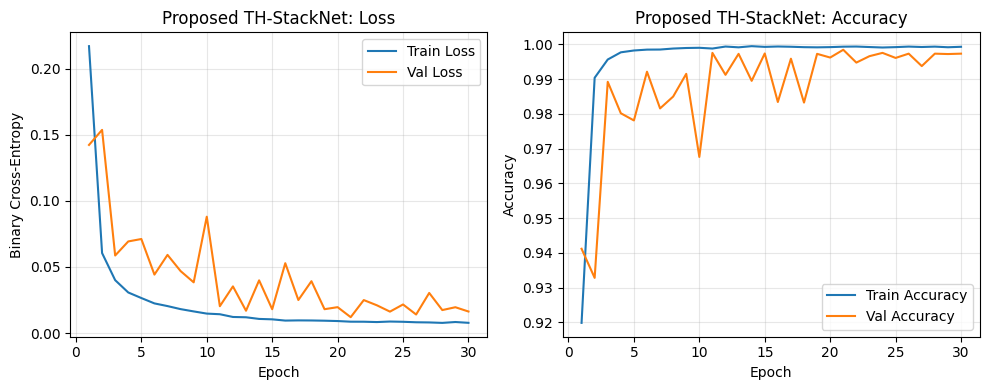

In [ ]:
import matplotlib.pyplot as plt

# Keras history থেকে data নিই
hist = history.history
epochs = range(1, len(hist["loss"]) + 1)

plt.figure(figsize=(10, 4))

# --------- Loss curve ---------
plt.subplot(1, 2, 1)
plt.plot(epochs, hist["loss"], label="Train Loss")
plt.plot(epochs, hist["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Binary Cross-Entropy")
plt.title("Proposed TH-StackNet: Loss")
plt.legend()
plt.grid(True, alpha=0.3)

# --------- Accuracy curve ---------
plt.subplot(1, 2, 2)
plt.plot(epochs, hist["accuracy"], label="Train Accuracy")
plt.plot(epochs, hist["val_accuracy"], label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Proposed TH-StackNet: Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


===== FINAL STACKING HYBRID (CatBoost + DNN + Meta — TEST METRICS =====
Accuracy : 0.9959
Precision: 0.9892
Recall   : 0.9968
F1-score : 0.9930
AUC      : 0.9999
Kappa    : 0.9901
MCC      : 0.9901
Jaccard  : 0.9861


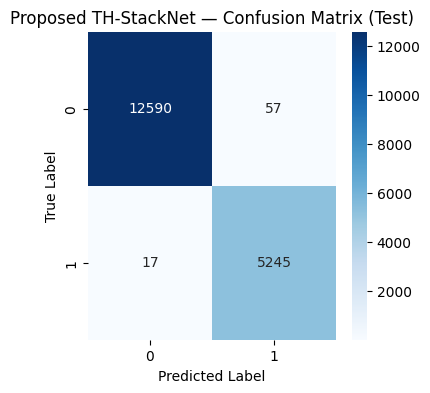

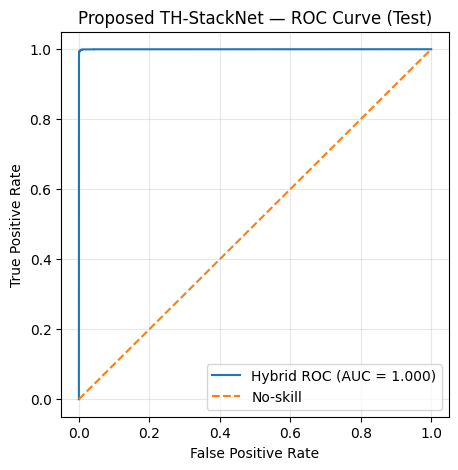

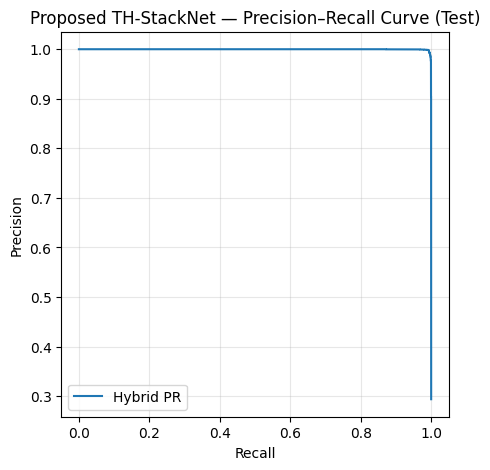

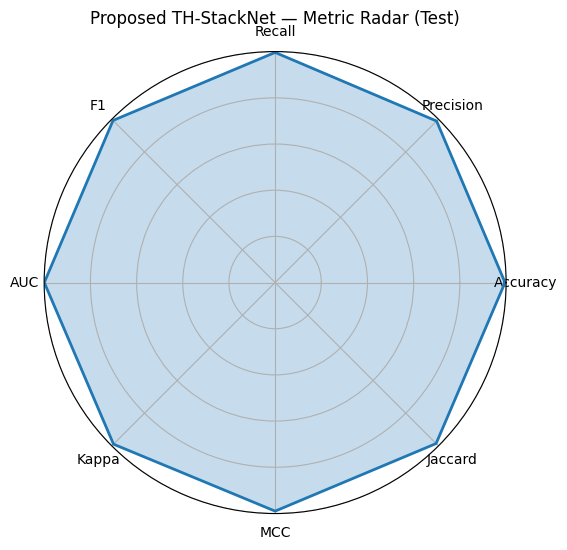

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, cohen_kappa_score, matthews_corrcoef,
    jaccard_score, confusion_matrix, roc_curve,
    precision_recall_curve
)

# ============================
# 1) Scalar metrics
# ============================
acc    = accuracy_score(y_test, y_pred_test)
prec   = precision_score(y_test, y_pred_test)
rec    = recall_score(y_test, y_pred_test)
f1     = f1_score(y_test, y_pred_test)
auc    = roc_auc_score(y_test, hyb_test_probs)   # prob থেকে
kappa  = cohen_kappa_score(y_test, y_pred_test)
mcc    = matthews_corrcoef(y_test, y_pred_test)
jacc   = jaccard_score(y_test, y_pred_test)

print("===== FINAL STACKING HYBRID (CatBoost + DNN + Meta — TEST METRICS =====")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")
print(f"Kappa    : {kappa:.4f}")
print(f"MCC      : {mcc:.4f}")
print(f"Jaccard  : {jacc:.4f}")

# ============================
# 2) Confusion Matrix + Heatmap
# ============================
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Proposed TH-StackNet — Confusion Matrix (Test)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ============================
# 3) ROC Curve (binary → positive class)
# ============================
fpr, tpr, roc_thr = roc_curve(y_test, hyb_test_probs)

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f"Hybrid ROC (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="No-skill")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Proposed TH-StackNet — ROC Curve (Test)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# ============================
# 4) Precision–Recall Curve
# ============================
prec_curve, rec_curve, pr_thr = precision_recall_curve(y_test, hyb_test_probs)

plt.figure(figsize=(5, 5))
plt.plot(rec_curve, prec_curve, label="Hybrid PR")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Proposed TH-StackNet — Precision–Recall Curve (Test)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# ============================
# 5) Radar Plot of Metrics
# ============================

# সব মেট্রিক 0–1 রেঞ্জে আছে, তাই সরাসরি নিলাম
metric_names  = ["Accuracy", "Precision", "Recall", "F1", "AUC", "Kappa", "MCC", "Jaccard"]
metric_values = [acc, prec, rec, f1, auc, kappa, mcc, jacc]

# radar plot এর জন্য last point = first point repeat
values = metric_values + [metric_values[0]]
angles = np.linspace(0, 2 * np.pi, len(values))

fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)
ax.plot(angles, values, linewidth=2)
ax.fill(angles, values, alpha=0.25)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(metric_names)
ax.set_yticklabels([])  # radial labels hide করলে clean দেখায়
ax.set_title("Proposed TH-StackNet — Metric Radar (Test)", pad=20)
plt.show()


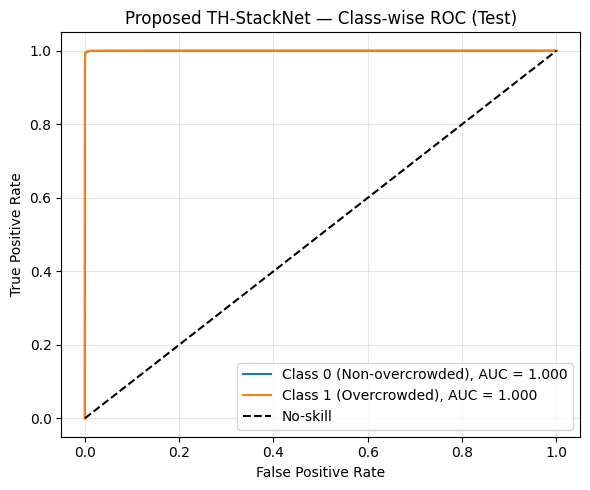

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# ============================
# Class-wise ROC for Hybrid
# ============================
# binary labels
y_true = y_test.values if hasattr(y_test, "values") else np.asarray(y_test)

# class-1 (overcrowded) probability = hybrid output
probs_1 = hyb_test_probs

# class-0 probability = 1 - p(class1)
probs_0 = 1.0 - probs_1

# ----- Class 1 vs rest -----
fpr1, tpr1, _ = roc_curve(y_true, probs_1, pos_label=1)
auc1 = auc(fpr1, tpr1)

# ----- Class 0 vs rest -----
# এখানে 0 কে positive ধরে ROC বানাচ্ছি → label উল্টো করে নিই
y_true_0 = 1 - y_true           # এখন "non-overcrowded" = 1
fpr0, tpr0, _ = roc_curve(y_true_0, probs_0, pos_label=1)
auc0 = auc(fpr0, tpr0)

# ============================
# Plot
# ============================
plt.figure(figsize=(6, 5))

plt.plot(fpr0, tpr0,
         label=f"Class 0 (Non-overcrowded), AUC = {auc0:.3f}")
plt.plot(fpr1, tpr1,
         label=f"Class 1 (Overcrowded), AUC = {auc1:.3f}")

# no-skill line
plt.plot([0, 1], [0, 1], 'k--', label="No-skill")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Proposed TH-StackNet — Class-wise ROC (Test)")
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


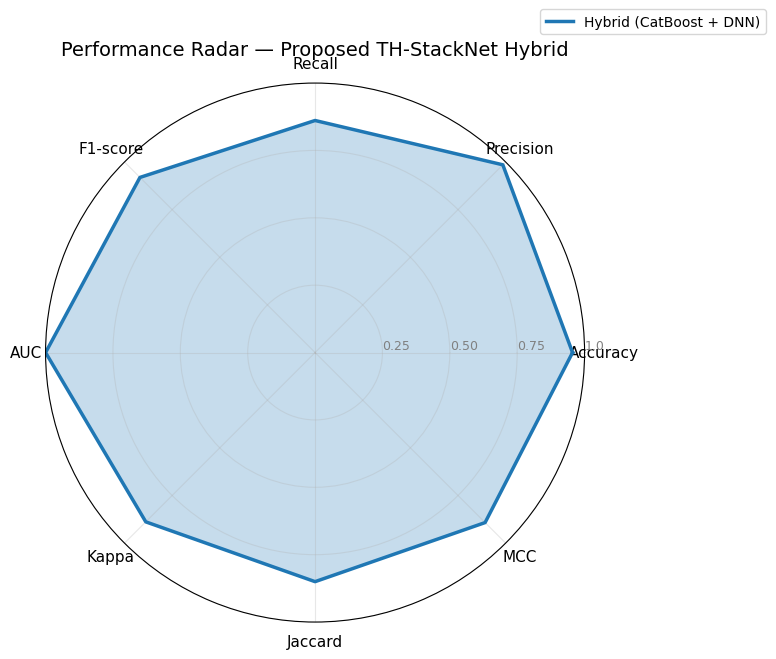

In [ ]:
# ====== RADAR PLOT FOR PROPOSED HYBRID (CatBoost + DNN) ======
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    precision_score, recall_score, roc_auc_score,
    cohen_kappa_score, jaccard_score, matthews_corrcoef
)

# 1) --- Compute all metrics on TEST set ---
acc    = accuracy_score(y_test, y_test_pred)
prec   = precision_score(y_test, y_test_pred)
rec    = recall_score(y_test, y_test_pred)
f1     = f1_score(y_test, y_test_pred)
auc    = roc_auc_score(y_test, hyb_test_probs)   # prob লাগে
kappa  = cohen_kappa_score(y_test, y_test_pred)
jacc   = jaccard_score(y_test, y_test_pred)
mcc    = matthews_corrcoef(y_test, y_test_pred)

metrics = {
    "Accuracy": acc,
    "Precision": prec,
    "Recall": rec,
    "F1-score": f1,
    "AUC": auc,
    "Kappa": kappa,
    "Jaccard": jacc,
    "MCC": mcc,
}

labels = list(metrics.keys())
values = list(metrics.values())

# Radar loop বন্ধ করার জন্য প্রথম মানটা শেষে আবার যোগ করি
values += values[:1]
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]

# 2) --- Plot Radar ---
plt.figure(figsize=(7, 7))
ax = plt.subplot(111, polar=True)

ax.plot(angles, values, linewidth=2.5, linestyle='solid',
        label="Hybrid (CatBoost + DNN)")
ax.fill(angles, values, alpha=0.25)

# category labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=11)

# radial ticks
ax.set_rlabel_position(0)
plt.yticks([0.25, 0.50, 0.75, 1.0],
           ["0.25", "0.50", "0.75", "1.0"],
           color="grey", size=9)
plt.ylim(0, 1)

plt.title("Performance Radar — Proposed TH-StackNet Hybrid", fontsize=14, pad=20)
plt.legend(loc="upper right", bbox_to_anchor=(1.35, 1.15))
plt.grid(True, alpha=0.3)
plt.show()


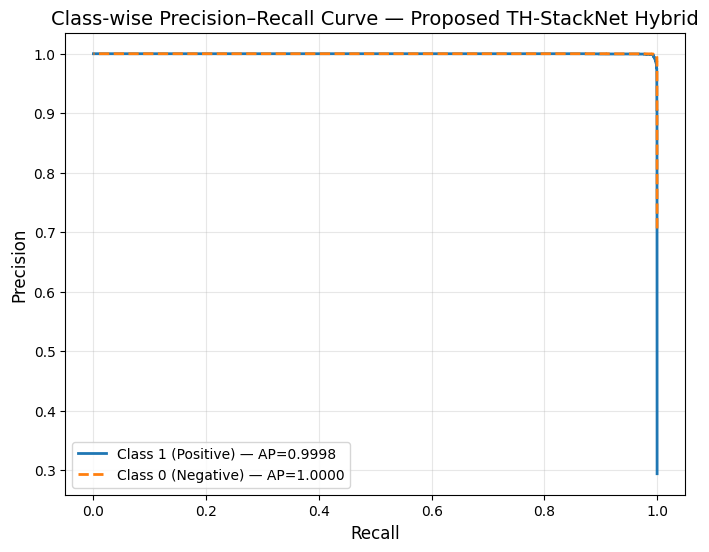

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np

# ============================
# Class-wise PR Curve
# ============================

# --- Class 1 ---
prec1, rec1, thr1 = precision_recall_curve(y_test, hyb_test_probs)
ap_1 = average_precision_score(y_test, hyb_test_probs)

# --- Class 0 ---
prec0, rec0, thr0 = precision_recall_curve(1 - y_test, 1 - hyb_test_probs)
ap_0 = average_precision_score(1 - y_test, 1 - hyb_test_probs)

# ============================
# Plot
# ============================

plt.figure(figsize=(8, 6))

plt.plot(rec1, prec1, label=f"Class 1 (Positive) — AP={ap_1:.4f}", linewidth=2)
plt.plot(rec0, prec0, label=f"Class 0 (Negative) — AP={ap_0:.4f}", linewidth=2, linestyle="--")

plt.xlabel("Recall", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.title("Class-wise Precision–Recall Curve — Proposed TH-StackNet Hybrid", fontsize=14)
plt.legend(loc="lower left")
plt.grid(alpha=0.3)
plt.show()


## SHAP Analysis

In [ ]:
!pip install shap --quiet

import shap
import numpy as np
import matplotlib.pyplot as plt

shap.initjs()


SHAP values shape: (17909, 26)


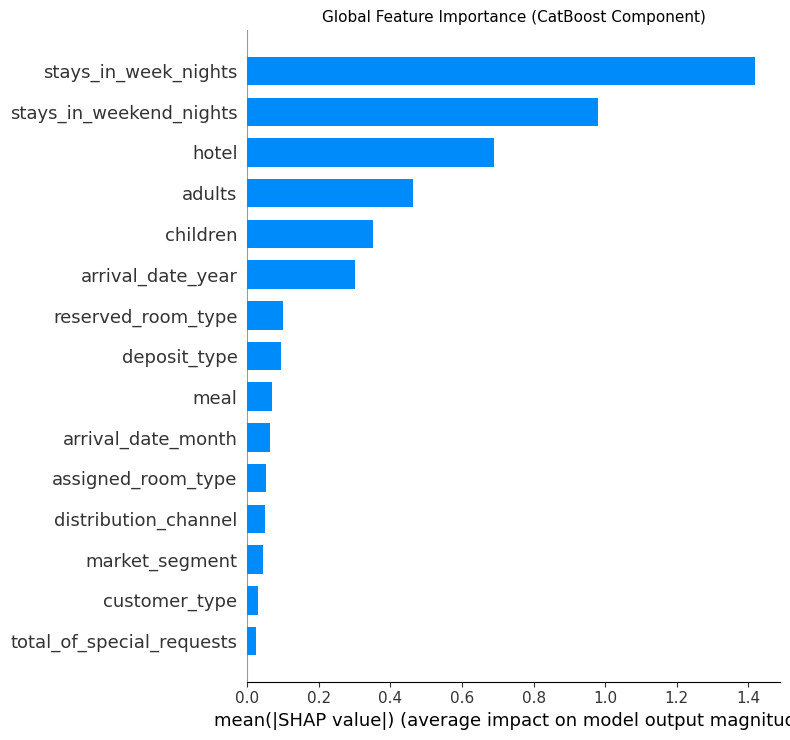

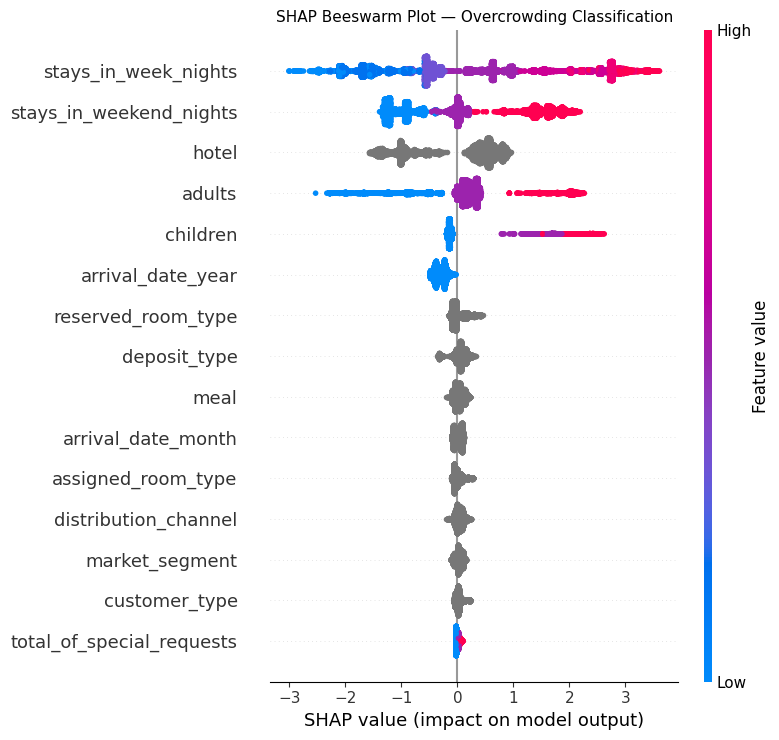

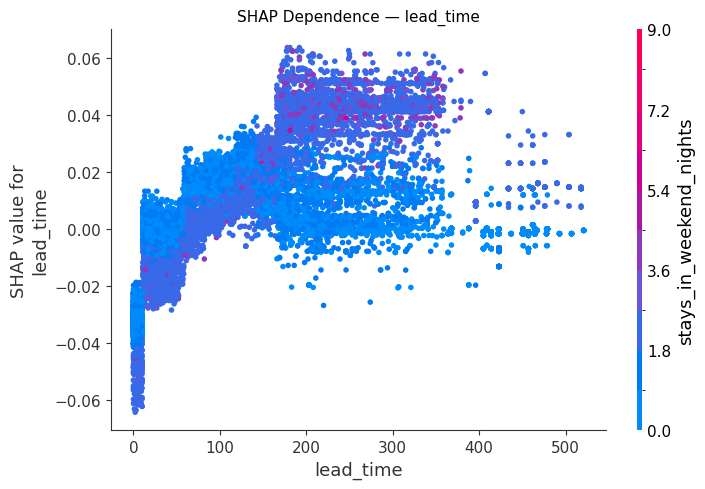

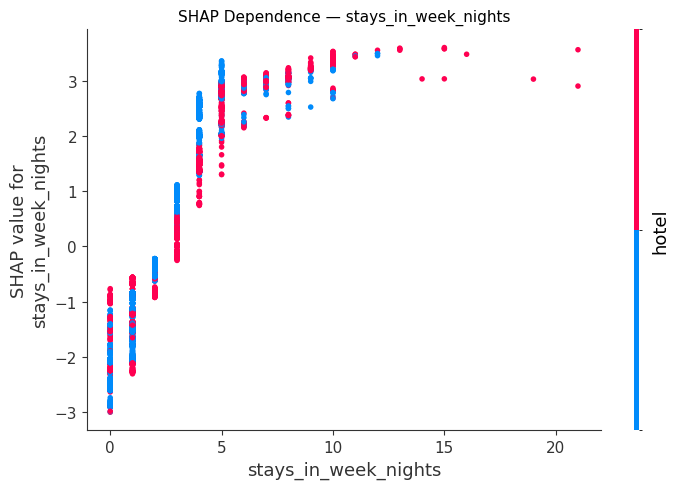

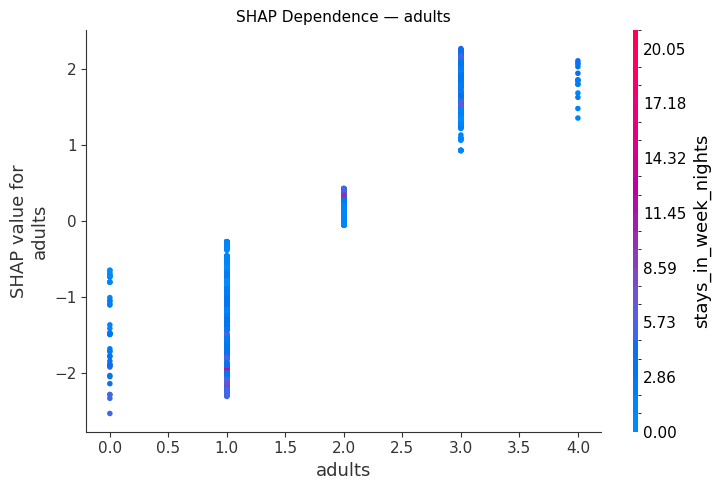

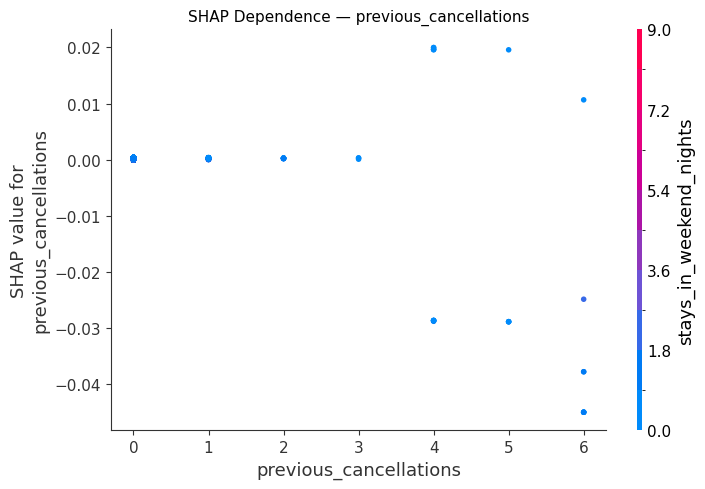

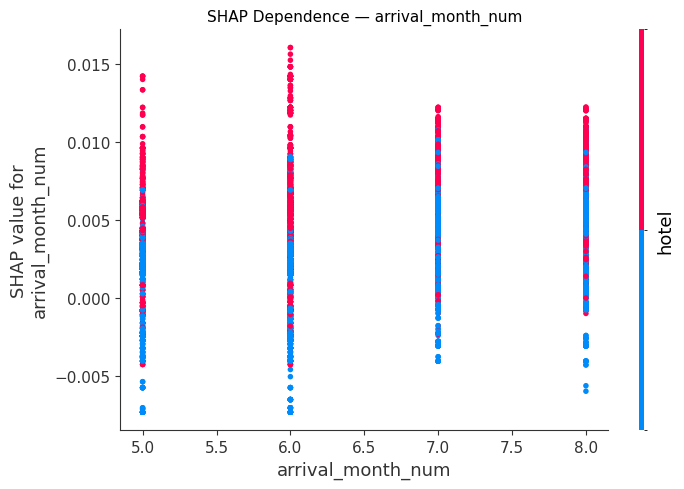

AttributeError: 'Explanation' object has no attribute 'expected_value'

In [ ]:
# ============================================
# FIXED SHAP ANALYSIS FOR CATBOOST (WORKS 100%)
# Using tree_path_dependent (no background)
# ============================================

!pip install shap --quiet
import shap
import numpy as np
import matplotlib.pyplot as plt

shap.initjs()

# ------------------------------------------------
# 1) Create SHAP explainer (CatBoost safe mode)
# ------------------------------------------------
explainer = shap.TreeExplainer(
    cb_reg,
    feature_perturbation="tree_path_dependent"   # ⭐ mandatory fix
)

# ------------------------------------------------
# 2) Compute SHAP values on test set
# ------------------------------------------------
shap_values_raw = explainer.shap_values(X_test_cb)

# CatBoost gives list [class0, class1]
if isinstance(shap_values_raw, list):
    shap_values = shap_values_raw[1]   # overcrowded class (1)
    base_value = explainer.expected_value[1]
else:
    shap_values = shap_values_raw
    base_value = explainer.expected_value

print("SHAP values shape:", np.array(shap_values).shape)

# ------------------------------------------------
# 3) Global Importance (Bar)
# ------------------------------------------------
plt.figure(figsize=(8,6))
shap.summary_plot(
    shap_values,
    X_test_cb,
    feature_names=feature_cols,
    plot_type="bar",
    max_display=15,
    show=False
)
plt.title("Global Feature Importance (CatBoost Component)", fontsize=11)
plt.tight_layout()
plt.show()

# ------------------------------------------------
# 4) Beeswarm plot
# ------------------------------------------------
plt.figure(figsize=(9,7))
shap.summary_plot(
    shap_values, X_test_cb,
    feature_names=feature_cols,
    max_display=15,
    show=False
)
plt.title("SHAP Beeswarm Plot — Overcrowding Classification", fontsize=11)
plt.tight_layout()
plt.show()

# ------------------------------------------------
# 5) Dependence plots (top features)
# ------------------------------------------------
top_feats = [
    "lead_time",
    "stays_in_week_nights",
    "adults",
    "previous_cancellations",
    "arrival_month_num"
]

for f in top_feats:
    if f in X_test_cb.columns:
        shap.dependence_plot(
            f, shap_values, X_test_cb,
            feature_names=feature_cols,
            show=False
        )
        plt.title(f"SHAP Dependence — {f}", fontsize=11)
        plt.tight_layout()
        plt.show()

# ------------------------------------------------
# 6) Local explanation (waterfall)
# ------------------------------------------------
idx = 0   # you can change this
x_one = X_test_cb.iloc[idx:idx+1]

one_shap = explainer.shap_values(x_one)
if isinstance(one_shap, list):
    one_shap = one_shap[1]

expl = shap.Explanation(
    values=one_shap[0],
    base_values=base_value,
    data=x_one.values[0],
    feature_names=x_one.columns.tolist()
)

shap.plots._waterfall.waterfall_legacy(expl)
plt.show()


SHAP values shape: (17909, 26)


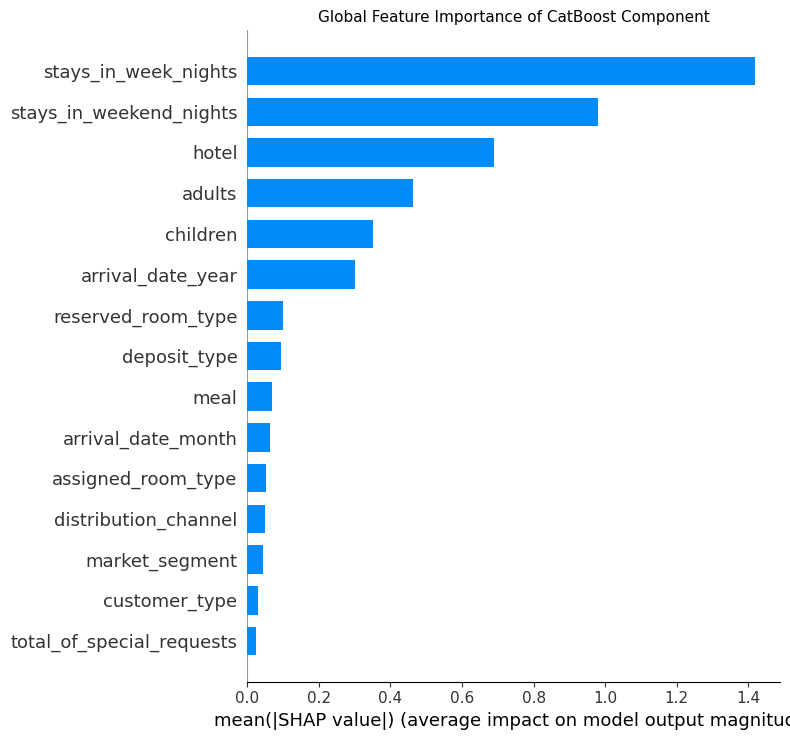

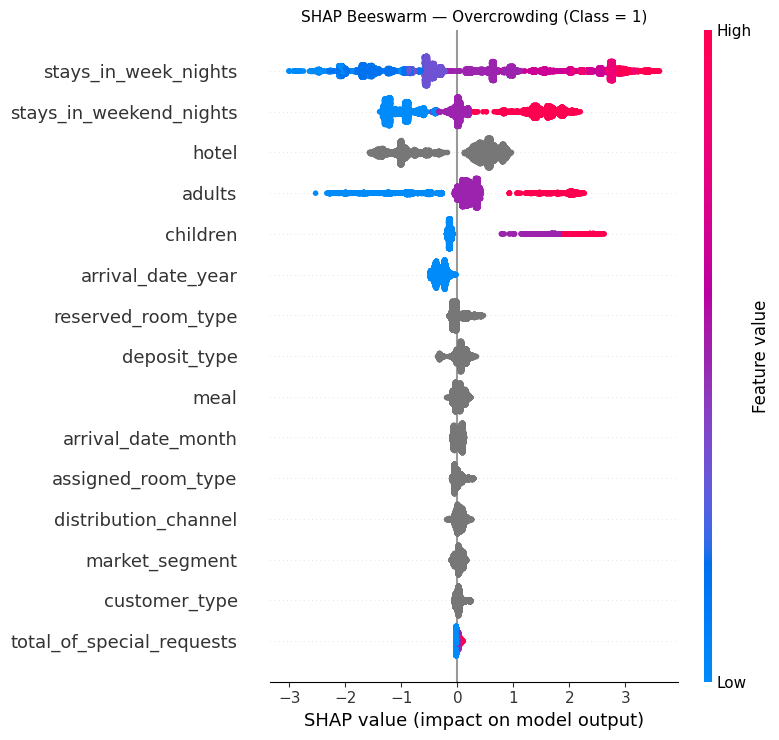

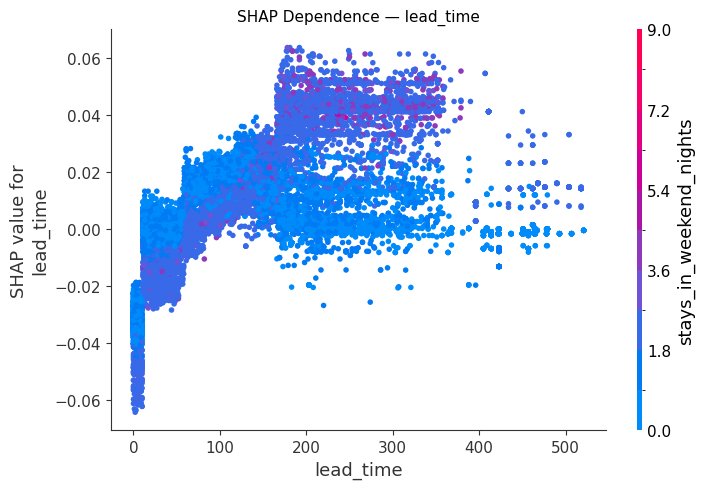

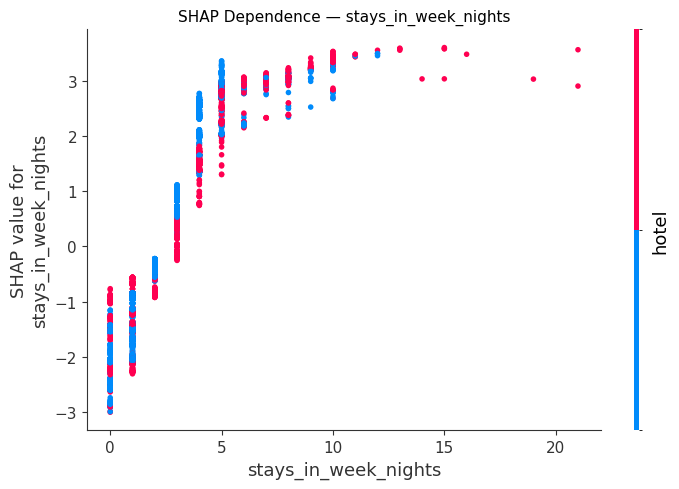

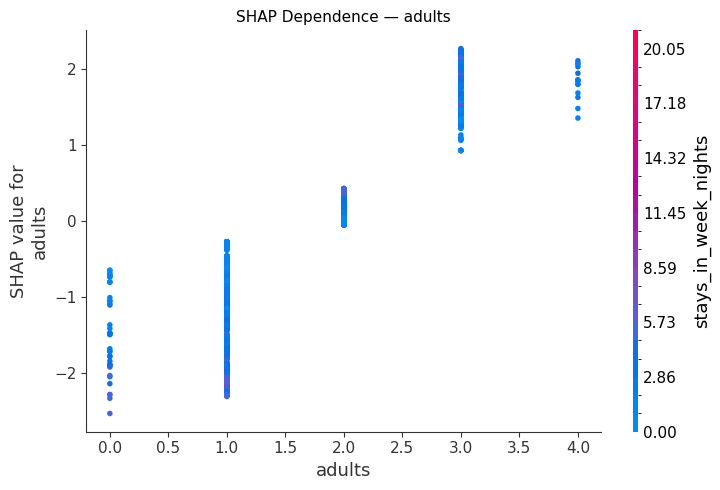

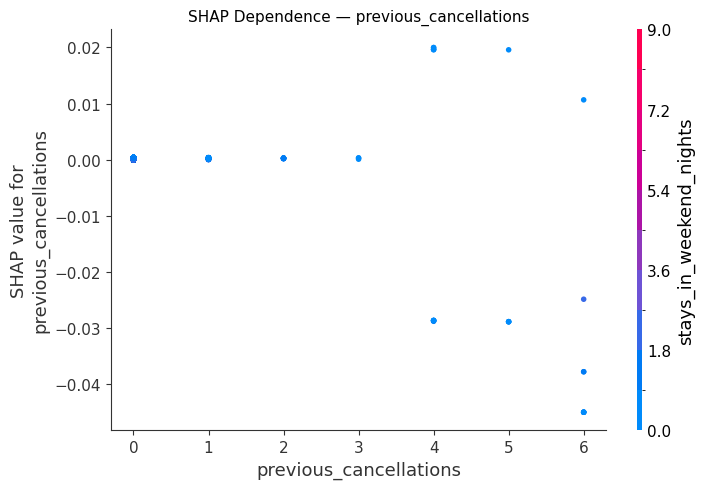

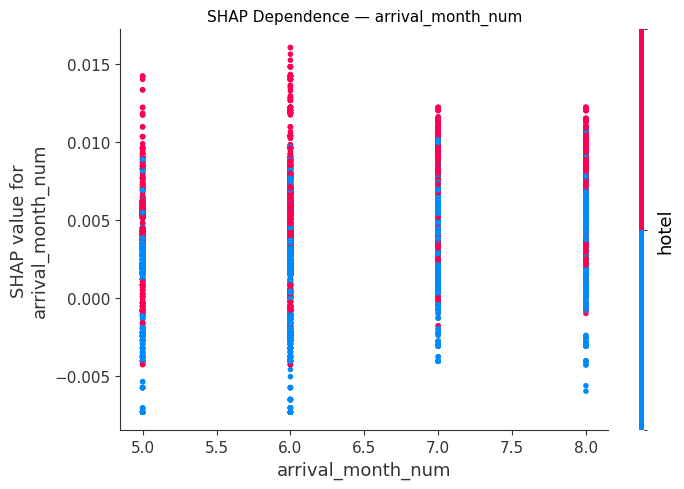

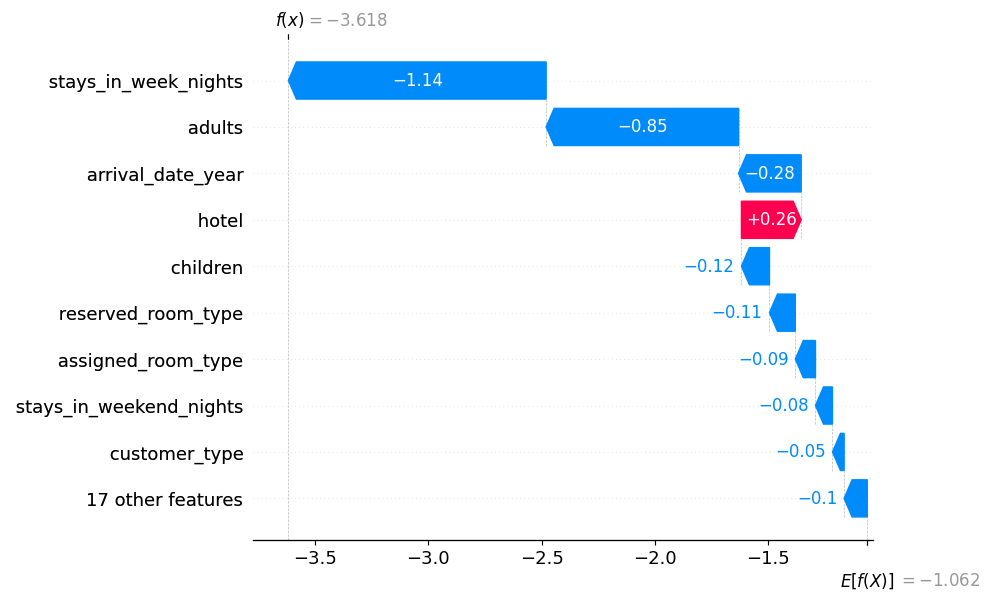

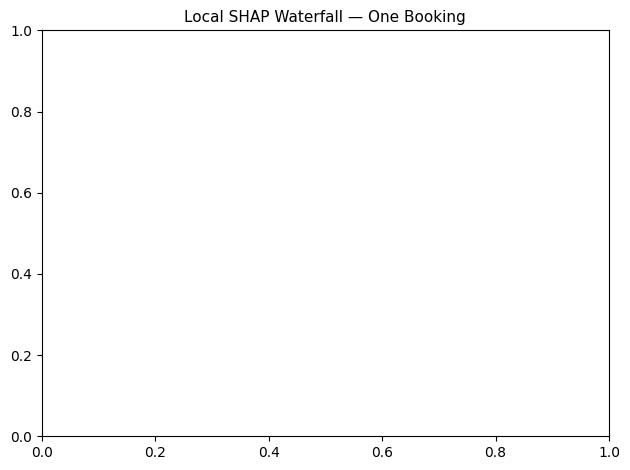

In [ ]:
!pip install shap --quiet

import shap
import numpy as np
import matplotlib.pyplot as plt

shap.initjs()

# =========================
# 1) TreeExplainer (CatBoost)
# =========================
explainer = shap.TreeExplainer(
    cb_reg,
    feature_perturbation="tree_path_dependent"  # ⭐ CatBoost + categorical safe mode
)

# Test set এর উপর SHAP value বের করি
shap_values_all = explainer.shap_values(X_test_cb)

# CatBoost সাধারণত list দেয়: [class0, class1]
if isinstance(shap_values_all, list):
    shap_values = shap_values_all[1]              # overcrowded = 1 ক্লাস
    base_value = explainer.expected_value[1]
else:
    shap_values = shap_values_all
    base_value = explainer.expected_value

print("SHAP values shape:", np.array(shap_values).shape)

# =========================
# 2) Global Importance (Bar)
# =========================
plt.figure(figsize=(8, 6))
shap.summary_plot(
    shap_values,
    X_test_cb,
    feature_names=feature_cols,
    plot_type="bar",
    max_display=15,
    show=False
)
plt.title("Global Feature Importance of CatBoost Component", fontsize=11)
plt.tight_layout()
plt.show()

# =========================
# 3) Global Importance (Beeswarm)
# =========================
plt.figure(figsize=(9, 7))
shap.summary_plot(
    shap_values,
    X_test_cb,
    feature_names=feature_cols,
    max_display=15,
    show=False
)
plt.title("SHAP Beeswarm — Overcrowding (Class = 1)", fontsize=11)
plt.tight_layout()
plt.show()

# =========================
# 4) Dependence plots for top features
# =========================
top_feats = [
    "lead_time",
    "stays_in_week_nights",
    "adults",
    "previous_cancellations",
    "arrival_month_num"
]

for f in top_feats:
    if f in X_test_cb.columns:
        shap.dependence_plot(
            f,
            shap_values,
            X_test_cb,
            feature_names=feature_cols,
            show=False
        )
        plt.title(f"SHAP Dependence — {f}", fontsize=11)
        plt.tight_layout()
        plt.show()

# =========================
# 5) Local Explanation (Waterfall for one sample)
# =========================
idx = 0  # চাইলে change করতে পারো
x_one = X_test_cb.iloc[idx:idx+1]

one_shap_all = explainer.shap_values(x_one)
if isinstance(one_shap_all, list):
    one_shap = one_shap_all[1][0]   # (features,)
else:
    one_shap = one_shap_all[0]

# ⚠ এখানে Explanation বানাবো না, direct legacy waterfall ব্যবহার করবো
from shap.plots._waterfall import waterfall_legacy

waterfall_legacy(
    expected_value=base_value,
    shap_values=one_shap,
    features=x_one.iloc[0],
    feature_names=x_one.columns.tolist()
)
plt.title("Local SHAP Waterfall — One Booking", fontsize=11)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    roc_auc_score, cohen_kappa_score, jaccard_score,
    matthews_corrcoef, classification_report, confusion_matrix
)

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# ============================================
# 1) DNN INPUT REBUILD (CONSISTENT SHAPE)
# ============================================
print("Rebuilding DNN inputs with ColumnTransformer...")

ct = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True), cat_features),
    ]
)

X_train_dl = ct.fit_transform(X_train_cb)
X_valid_dl = ct.transform(X_valid_cb)
X_test_dl  = ct.transform(X_test_cb)

X_train_dl = X_train_dl.toarray()
X_valid_dl = X_valid_dl.toarray()
X_test_dl  = X_test_dl.toarray()

print("DNN input shapes:", X_train_dl.shape, X_valid_dl.shape, X_test_dl.shape)

# ============================================
# 2) BUILD & TRAIN REGULARIZED DNN
# ============================================
input_dim = X_train_dl.shape[1]

inp = Input(shape=(input_dim,), name="tab_input")

x = Dense(256, activation="relu",
          kernel_regularizer=tf.keras.regularizers.l2(1e-4))(inp)
x = Dropout(0.4)(x)
x = Dense(128, activation="relu",
          kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x = Dropout(0.3)(x)
x = Dense(64, activation="relu",
          kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x = Dropout(0.2)(x)
out = Dense(1, activation="sigmoid")(x)

dnn_model = Model(inputs=inp, outputs=out)
dnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=[tf.keras.metrics.AUC(name="auc")]
)

early_stop = EarlyStopping(
    monitor="val_auc",
    mode="max",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

print("\nTraining DNN...")
history = dnn_model.fit(
    X_train_dl, y_train,
    validation_data=(X_valid_dl, y_valid),
    epochs=50,
    batch_size=512,
    callbacks=[early_stop],
    verbose=1
)

# ============================================
# 3) BASE MODEL PROBABILITIES (CAT + DNN)
# ============================================

# CatBoost থেকে
valid_probs_cb = cb_reg.predict_proba(X_valid_cb)[:, 1]
test_probs_cb  = cb_reg.predict_proba(X_test_cb)[:, 1]

# DNN থেকে
valid_probs_dnn = dnn_model.predict(X_valid_dl, batch_size=512, verbose=0).ravel()
test_probs_dnn  = dnn_model.predict(X_test_dl,  batch_size=512, verbose=0).ravel()

print("\nShapes check:")
print(" valid_probs_cb :", valid_probs_cb.shape)
print(" valid_probs_dnn:", valid_probs_dnn.shape)
print(" test_probs_cb  :", test_probs_cb.shape)
print(" test_probs_dnn :", test_probs_dnn.shape)
print(" len(y_valid), len(y_test):", len(y_valid), len(y_test))

# ============================================
# 4) META FEATURES FOR STACKING
# ============================================
meta_train = np.column_stack([valid_probs_cb, valid_probs_dnn])
meta_test  = np.column_stack([test_probs_cb,  test_probs_dnn])

print("\nMeta-train shape:", meta_train.shape)
print("Meta-test  shape:", meta_test.shape)

assert meta_train.shape[0] == len(y_valid)
assert meta_test.shape[0]  == len(y_test)

# ============================================
# 5) META-LEARNER (LOGISTIC REGRESSION)
# ============================================
meta_clf = LogisticRegression(
    penalty="l2",
    C=1.0,              # চাইলে 0.5/0.7 করে দেখতে পারো
    class_weight="balanced",
    max_iter=2000,
    n_jobs=-1,
    random_state=42
)

meta_clf.fit(meta_train, y_valid)

valid_meta_probs = meta_clf.predict_proba(meta_train)[:, 1]
test_meta_probs  = meta_clf.predict_proba(meta_test)[:, 1]

# ============================================
# 6) HELPER: FULL METRIC EVALUATION
# ============================================
def eval_all(y_true, y_proba, thr):
    y_pred = (y_proba >= thr).astype(int)
    acc    = accuracy_score(y_true, y_pred)
    prec   = precision_score(y_true, y_pred)
    rec    = recall_score(y_true, y_pred)
    f1     = f1_score(y_true, y_pred)
    auc    = roc_auc_score(y_true, y_proba)
    kappa  = cohen_kappa_score(y_true, y_pred)
    jacc   = jaccard_score(y_true, y_pred)
    mcc    = matthews_corrcoef(y_true, y_pred)
    return {
        "thr": thr,
        "acc": acc,
        "prec": prec,
        "rec": rec,
        "f1": f1,
        "auc": auc,
        "kappa": kappa,
        "jaccard": jacc,
        "mcc": mcc,
        "y_pred": y_pred
    }

# ============================================
# 7) THRESHOLD SCAN (VALID)
# ============================================
print("\n[STACKING HYBRID (CatBoost + DNN + Meta) — VALID Threshold scan]")
best = None

for t in np.linspace(0.3, 0.9, 13):   # 0.30, 0.35, ..., 0.90
    m = eval_all(y_valid, valid_meta_probs, t)
    print(
        f"{t:.2f} => Acc:{m['acc']:.4f}, "
        f"Prec:{m['prec']:.4f}, Rec:{m['rec']:.4f}, "
        f"F1:{m['f1']:.4f}, AUC:{m['auc']:.4f}"
    )
    if (best is None) or (m["f1"] > best["f1"]):
        best = m

print(f"\nBest threshold on VALID: {best['thr']:.2f} (F1={best['f1']:.4f})")
best_thr = best["thr"]

# ============================================
# 8) FINAL TEST EVALUATION
# ============================================
final = eval_all(y_test, test_meta_probs, best_thr)
y_test_pred = final["y_pred"]

print("\n===== FINAL STACKING HYBRID (CatBoost + DNN + Meta) — TEST =====")
print(f"Threshold : {final['thr']:.2f}")
print(f"Accuracy  : {final['acc']:.4f}")
print(f"Precision : {final['prec']:.4f}")
print(f"Recall    : {final['rec']:.4f}")
print(f"F1-score  : {final['f1']:.4f}")
print(f"AUC       : {final['auc']:.4f}")
print(f"Kappa     : {final['kappa']:.4f}")
print(f"Jaccard   : {final['jaccard']:.4f}")
print(f"MCC       : {final['mcc']:.4f}")

print("\nClassification Report (TEST):")
print(classification_report(y_test, y_test_pred, digits=4))

print("Confusion Matrix (TEST):")
print(confusion_matrix(y_test, y_test_pred))
